<a href="https://colab.research.google.com/github/Muhammadsulton1/MIPT_Data_analys/blob/main/Lesson8_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Семинар 8 (неделя 9): Кластеризация
=====

- [Домашнее задание](#HW)

In [ ]:
# Импорт библиотек для работы со статистикой
import numpy as np
import pandas as pd
import scipy.stats as sts
import statsmodels as stm


# Импорт библиотек для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns

# Стиль для графиков
plt.style.use('ggplot')
%matplotlib inline

## Швейцарские банкноты

In [ ]:
SBN = pd.read_csv('swiss_bank_notes.csv', index_col=0)
SBN.tail()

,Status,Length,Left,Right,Bottom,Top,Diagonal
196,counterfeit,215.0,130.4,130.3,9.9,12.1,139.6
197,counterfeit,215.1,130.3,129.9,10.3,11.5,139.7
198,counterfeit,214.8,130.3,130.4,10.6,11.1,140.0
199,counterfeit,214.7,130.7,130.8,11.2,11.2,139.4
200,counterfeit,214.3,129.9,129.9,10.2,11.5,139.6


In [ ]:
SBN['Status'].value_counts()

genuine        100
counterfeit    100
Name: Status, dtype: int64

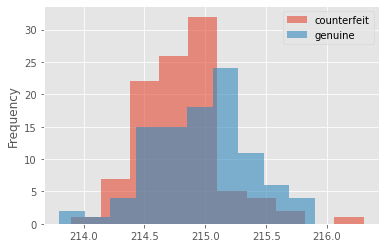

In [ ]:
SBN.groupby('Status')['Length'].plot.hist(alpha=0.6)
plt.legend();

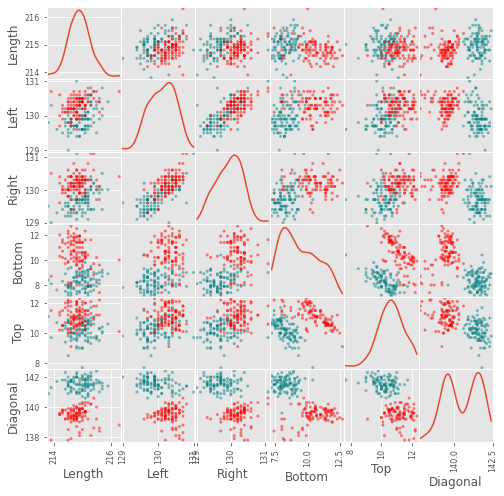

In [ ]:
from pandas.plotting import scatter_matrix
colors = {'genuine': 'teal', 'counterfeit': 'red'}
scatter_matrix(SBN,
               figsize = (8, 8),
               diagonal = 'kde',
               c = SBN['Status'].replace(colors),
               alpha = 0.5,
              );

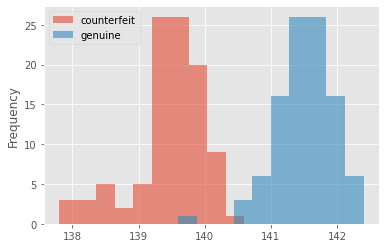

In [ ]:
SBN.groupby('Status')['Diagonal'].plot.hist(alpha=0.6)
plt.legend(loc='upper left')

<AxesSubplot:xlabel='Diagonal', ylabel='Length'>

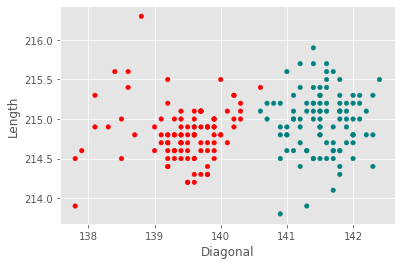

In [ ]:
SBN.plot.scatter(x='Diagonal', y='Length', c = SBN['Status'].replace(colors))

---
---
## Сегментация покупателей



In [ ]:
# conda install -c anaconda openpyxl

In [ ]:
RTL = pd.read_excel("Online Retail.xlsx")

In [ ]:
print(RTL.shape)
RTL.tail()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [ ]:
# Проверка наличия пропусков:

RTL.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
# Удаляем записи без указанного ID покупателя:

RTL = RTL[RTL['CustomerID'].notnull()]
RTL.shape

(406829, 8)

In [ ]:
# Снова проверим пропуски:

RTL.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

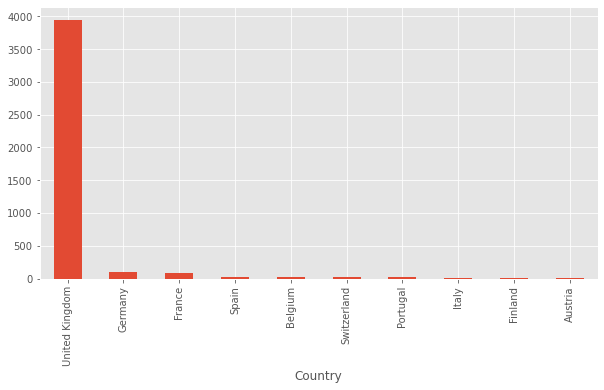

In [ ]:
# Посмотрим на топ-10 стран по уникальным пользователям:

g = (RTL.groupby('Country')['CustomerID']
     .agg('nunique')
     .sort_values(ascending=False)[:10]
     .plot(kind='bar', figsize=(10,5))
    )

g;

In [ ]:
# Будем работать только с Великобританией:

uk_data = RTL[RTL.Country=='United Kingdom']
uk_data.shape

(361878, 8)

In [ ]:
uk_data.describe()

,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368
std,263.129266,70.654731,1594.402590
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15514.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
# Видно, что судя по данным некоторые клиенты сделали отрицательные заказы.
# Это явная ошибка в данных. Отфильтруем только те заказы,
# где сумма покупки оказалась положительной:

uk_data = uk_data[uk_data['Quantity'] > 0]
uk_data.describe()

,Quantity,UnitPrice,CustomerID
count,354345.000000,354345.000000,354345.000000
mean,12.048913,2.963793,15552.436219
std,190.428127,17.862067,1594.546025
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15522.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,8142.750000,18287.000000


Будем сегментировать клиентов по __RFM__:

- __Recency__ (Свежесть) - число дней насколько давно пользователь что-то у нас покупал
- __Frequency__ (Частота) - насколько много заказов пользовать сделал
- __Monetary__ (Деньги) - сколько в сумме денег потратил

Клиенты, которые пришли недавно, много и часто покупали - лучшие клиенты.

In [ ]:
uk_data = uk_data[['CustomerID',
                   'InvoiceDate',
                   'InvoiceNo',
                   'Quantity',
                   'UnitPrice']]
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55
1,17850.0,2010-12-01 08:26:00,536365,6,3.39
2,17850.0,2010-12-01 08:26:00,536365,8,2.75
3,17850.0,2010-12-01 08:26:00,536365,6,3.39
4,17850.0,2010-12-01 08:26:00,536365,6,3.39


In [ ]:
# Колонка с итоговой суммой, потраченной при покупке
uk_data['TotalPrice'] = uk_data['Quantity'] * uk_data['UnitPrice']

In [ ]:
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


In [ ]:
# Период времени, когда поступали заказы
uk_data['InvoiceDate'].min(), uk_data['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:49:00'))

In [ ]:
import datetime as dt
PRESENT = dt.datetime(2011,12,10) # самая новая дата

uk_data['InvoiceDate'] = pd.to_datetime(uk_data['InvoiceDate'])

In [ ]:
rfm = (uk_data.groupby('CustomerID')
       .agg({
           'InvoiceDate': lambda date: (PRESENT - date.max()).days, # число дней с последней покупки
           'InvoiceNo': 'count',                                    # число заказов
           'TotalPrice': 'sum'                                      # суммарные траты
       })
      )

In [ ]:
rfm

,InvoiceDate,InvoiceNo,TotalPrice
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34
...,...,...,...
18280.0,277,10,180.60
18281.0,180,7,80.82
18282.0,7,12,178.05


In [ ]:
rfm.columns = ['recency', 'frequency', 'monetary']

rfm.head()

,recency,frequency,monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34


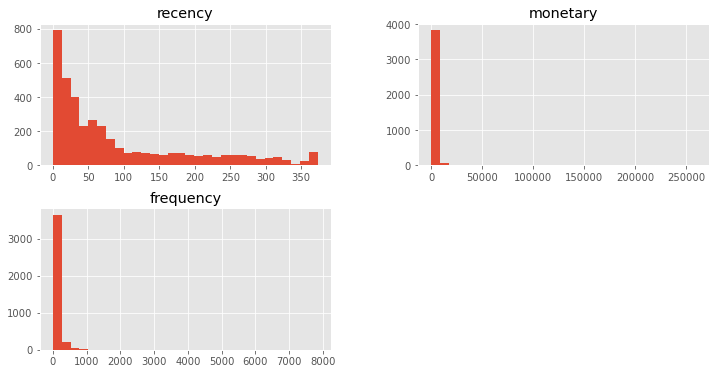

In [ ]:
# Посмотрим на то как распределены наши характеристики, которые мы построили для сегментации:

rfm[['recency', 'monetary', 'frequency']].hist(figsize=(12,6), bins=30);

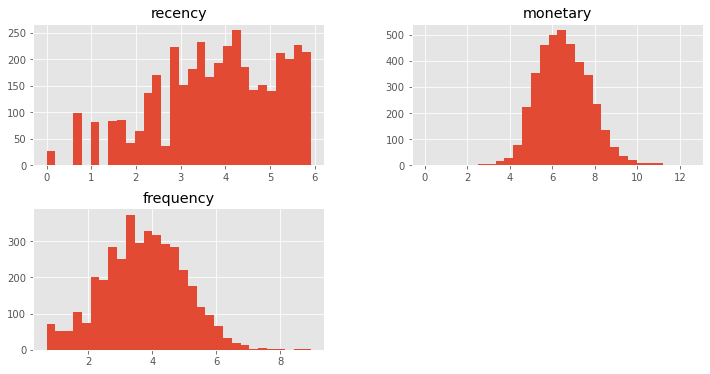

In [ ]:
# Видим довольно длинные хвосты.
# Чтобы визуализация оказалась более информативной,
# прологарифмируем наши переменные:

g = (rfm[['recency', 'monetary', 'frequency']]
     .apply(lambda w: np.log(w + 1))
     .hist(figsize=(12,6), bins=30)
    )

g;

In [ ]:
rfm[['recency', 'frequency', 'monetary']] = \
rfm[['recency', 'frequency', 'monetary']].apply(lambda w: np.log(w + 1))

In [ ]:
# Мы будем использовать для сегментации квартили, поэтому для нас выбросы не проблема.
# Данные от них очищать не будем. Номер соотвествующего квартиля помогает найти команда qcut():

rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])

In [ ]:
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,5.786897,0.693147,11.253955,4,4,1
12747.0,1.098612,4.644391,8.342128,1,1,1
12748.0,0.000000,8.433159,10.425868,1,1,1
12749.0,1.386294,5.298317,8.316760,1,1,1
12820.0,1.386294,4.094345,6.849427,1,2,2


In [ ]:
# Создадим единую колонку с номерами сегментов:

rfm['RFM_Score'] = rfm.r_quartile.astype(str) \
                 + rfm.f_quartile.astype(str) \
                 + rfm.m_quartile.astype(str)

rfm

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
12346.0,5.786897,0.693147,11.253955,4,4,1,441
12747.0,1.098612,4.644391,8.342128,1,1,1,111
12748.0,0.000000,8.433159,10.425868,1,1,1,111
12749.0,1.386294,5.298317,8.316760,1,1,1,111
12820.0,1.386294,4.094345,6.849427,1,2,2,122
...,...,...,...,...,...,...,...
18280.0,5.627621,2.397895,5.201806,4,4,4,444
18281.0,5.198497,2.079442,4.404522,4,4,4,444
18282.0,2.079442,2.564949,5.187665,1,4,4,144


In [ ]:
# Посмотрим в какой сегмент сколько пользователей попало.
# Нас больше всего интересует сегмент 111. Меньше всего 444

rfm['RFM_Score'].value_counts()[:15]

111    409
444    343
211    186
433    180
344    168
222    156
322    142
333    141
122    124
244    112
233    107
443    104
311     92
434     90
212     83
Name: RFM_Score, dtype: int64

In [ ]:
# Выберем из таблички наших самых преданных покупателей:

rfm[rfm['RFM_Score'] == '111'].sort_values('monetary', ascending=False).head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
18102.0,0.000000,6.068426,12.467122,1,1,1,111
17450.0,2.197225,5.823046,12.178454,1,1,1,111
17511.0,1.098612,6.871091,11.419311,1,1,1,111
16684.0,1.609438,5.627621,11.107279,1,1,1,111
14096.0,1.609438,8.539346,11.084690,1,1,1,111


Для визуализации оставим только те сегменты, куда попало больше $100$ человек.

In [ ]:
segments = rfm['RFM_Score'].value_counts()
big_segments = segments[segments > 100].index.values
big_segments

array(['111', '444', '211', '433', '344', '222', '322', '333', '122',
       '244', '233', '443'], dtype=object)

Нарисуем интерактивную визуализацию

In [ ]:
# conda install -c plotly plotly
# !pip install plotly

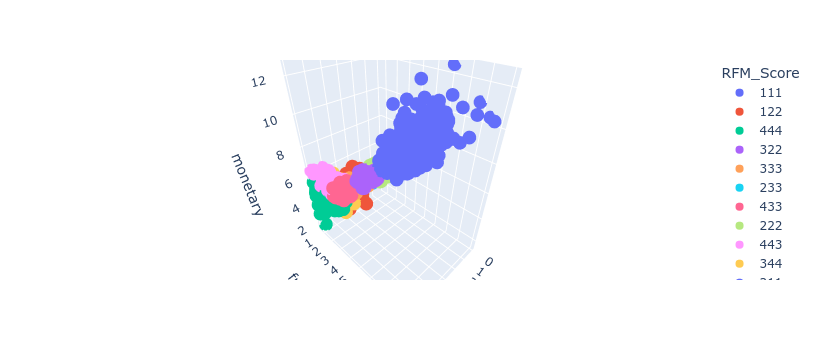

In [ ]:
import plotly.express as px

px.scatter_3d(rfm[rfm.RFM_Score.isin(big_segments)],
              x='recency',
              y='frequency',
              z='monetary',
              color='RFM_Score'
             )

---
---
# __Иерархический кластерный анализ__

## Пример 1. Напитки

In [ ]:
BVR = pd.read_csv("beverage_r.csv", sep=";", index_col='numb.obs')
BVR.tail()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP
numb.obs,,,,,,,,
30,0,1,1,0,0,0,1,0
31,1,0,0,0,1,0,0,1
32,0,1,1,0,0,0,1,0
33,1,0,0,0,1,0,0,1
34,0,1,1,1,0,0,1,0


Применим алгоритм иерархической кластеризации и построим дендрограмму. Все необходимые вычисления проводятся в функции linkage. Кроме самих данных ей нужно передать на вход два аргумента: метод вычисления расстояний между кластерами (```ward```, ```single```, ```complete```, ```average```) и метрику (```euclidean``` (default), ```cityblock``` aka Manhattan, ```hamming```, ```cosine```). См. [документацию]( https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html).

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, set_link_color_palette

# Объект, в котором будет хранится информация о последовательном слиянии кластеров
link_BVR = linkage(BVR, 'ward', 'euclidean')

Объект ```link``` представляет собой матрицу ```(n-1) x 4```, где ```n``` -- число наблюдений. Каждая строка матрицы представляет собой результат слияния очередной пары кластеров с номерами ```link[i, 0]``` и ```link[i, 1]```. Новому кластеру присваивается номер ```n + i```. ```link[i, 2]``` означает расстояние между слитыми кластерами, а ```link[i, 3]``` -- размер нового кластера.

In [ ]:
link_BVR

array([[ 5.        , 10.        ,  0.        ,  2.        ],
       [ 1.        ,  2.        ,  0.        ,  2.        ],
       [ 4.        , 35.        ,  0.        ,  3.        ],
       [ 3.        , 22.        ,  0.        ,  2.        ],
       [20.        , 36.        ,  0.        ,  4.        ],
       [ 6.        , 33.        ,  0.        ,  2.        ],
       [ 9.        , 30.        ,  0.        ,  2.        ],
       [13.        , 28.        ,  0.        ,  2.        ],
       [32.        , 40.        ,  0.        ,  3.        ],
       [17.        , 23.        ,  0.        ,  2.        ],
       [11.        , 26.        ,  0.        ,  2.        ],
       [14.        , 29.        ,  0.        ,  2.        ],
       [25.        , 37.        ,  0.        ,  3.        ],
       [31.        , 45.        ,  0.        ,  3.        ],
       [21.        , 38.        ,  0.        ,  5.        ],
       [ 0.        ,  7.        ,  1.        ,  2.        ],
       [18.        , 27.

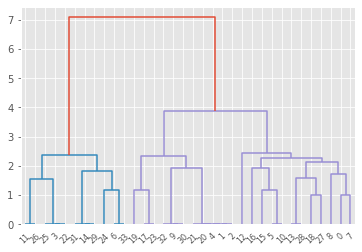

In [ ]:
# Функция для построения дендрограммы
dn = dendrogram(link_BVR)

Алгоритм подкрасил в дендрограмме два кластера, но здесь скорее кластера всё-таки три. Теперь хочется посмотреть, какими характеристиками различаются наши кластеры.

Сначала добавим к данным колонку ```cluster```, в которую запишем номер кластера, в которую попал объект. Это сделаем с помощью функции ```fcluster```. В качестве первого аргумента передаём объект ```linkage```, полученный выше. Третьим аргументом ```criterion``` передаём критерий для разбиения на кластеры (```distance``` для остановки разбиения по расстоянию между кластерами и ```maxclust``` для разбиения по заданному числу кластеров). Вторым же аргументом является либо пороговое значение для расстояния между кластерами, либо количество кластеров, в зависимости от аргумента ```criterion```.

### Ручной выбор числа кластеров

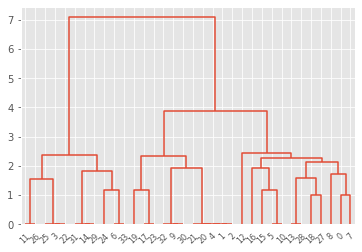

In [ ]:
#  Убираем автоматическое определение числа кластеров
dn = dendrogram(link_BVR, color_threshold = -1)

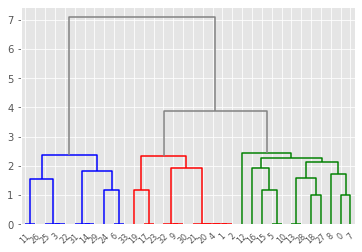

In [ ]:
set_link_color_palette(['b','r', 'g', 'm', 'orange', 'teal'])
dn = dendrogram(link_BVR,
                color_threshold = 3,
                above_threshold_color="grey"
               )

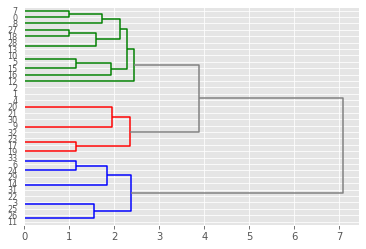

In [ ]:
dn = dendrogram(link_BVR,
                color_threshold = 3,
                above_threshold_color="grey",
                orientation = "right"
               );

In [ ]:
# Останавливаем объединение, если расстояние между кластерами превышает 3
BVR['cluster'] = fcluster(link_BVR, 3, criterion='distance')

Теперь вычислим средние значения всех характеристик, сгруппировав данные по номеру кластера. Используем стандартную конструкцию: вызов метода ```groupby``` с последующим применением группирующей функции.

In [ ]:
BVR.groupby('cluster').mean()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP
cluster,,,,,,,,
1,0.00,1.000000,0.545455,0.545455,0.000000,0.000000,0.909091,0.000000
2,1.00,0.272727,0.090909,0.000000,1.000000,0.000000,0.000000,0.272727
3,0.75,0.250000,0.083333,0.083333,0.416667,0.916667,0.083333,0.500000


Также интересно узнать, сколько наблюдений попало в каждый кластер. Для этого также применяем вызов ```groupy``` с последующим применением метода ```size```.

In [ ]:
BVR.groupby('cluster').size()

cluster
1    11
2    11
3    12
dtype: int64

In [ ]:
#  Кто попал в 1-й кластер?
BVR[BVR['cluster']==1].index.values

array([ 4,  7, 12, 15, 23, 25, 26, 27, 30, 32, 34])

### Автоматический выбор числа кластеров

А можно было выбрать число кластеров не на глаз по дендрограмме, а автоматически, тем более если данных много? Можно. Построим график, носящий название __"каменистая осыпь"__. Напомним, в матрице ```link``` во второй колонке хранятся расстояния между парами слитых кластеров. По построению, строки матрицы упорядочены по этой колонке.

In [ ]:
dist = link_BVR[:, 2]
dist

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 1.15470054, 1.15470054, 1.15470054,
       1.54919334, 1.58113883, 1.73205081, 1.82574186, 1.91485422,
       1.93649167, 2.12132034, 2.27636073, 2.33711814, 2.37920282,
       2.446395  , 3.87646865, 7.09212963])

Таким образом, можно построить график зависимости расстояний между кластерами от шага слияния (обратного), и посмотреть, начиная с какого момента это расстояние перестанет значительно меняться.

Text(22, 2.6, '4 clusters')

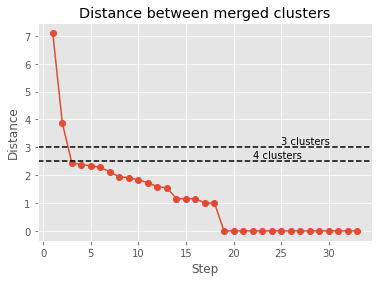

In [ ]:
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Distance between merged clusters')
plt.xlabel('Step')
plt.ylabel('Distance')
plt.axhline(3, c='k', linestyle='dashed')
plt.axhline(2.52, c='k', linestyle='dashed')
plt.text(25, 3.1, '3 clusters')
plt.text(22, 2.6, '4 clusters')

Из картинки видно, что если мы остановимся объединять кластеры при расстоянии равном примерно 2.5, мы получим 4 кластера, а при равном 3 - 3 кластера.

Однако строго говоря, этот способ всё ещё немасштабируем для больших данных. Но его можно просто поправить, включая в график не все подряд слияния, а только несколько последних. И если уж мы совсем хотим автомаизировать процесс, то факт сильного изменения расстояний между кластерами можно фиксировать с помощью производной: там где график выходит на горизонталь, производная станет почти нулём.

## Пример 2. Соискатели

Рассмотрим данные о приеме на работу на некоторое предприятие. 18 претендентов прошли 10 различных тестов в кадровом отделе. Максимальная оценка, которую можно было получить на каждом из тестов, составляет 10 баллов, минимальная - 1. Проверялись следующие качества:
1. Память на числа
2. Умение решать математические задачи
3. Находчивость при прямом диалоге
4. Умение составлять алгоритмы
5. Уверенность во время выступления
6. Командный дух
7. Находчивость
8. Сотрудничество
9. Признание в коллективе
10. Сила убеждения

Результаты теста хранятся в файле ```assess.dat``` в переменных t1 – t10, соответственно. В файле присутствуют также переменные с номером и фамилией участника.

Задача – провести кластерный анализ с целью обнаружения групп кандидатов, близких по своим качествам.

Сравнить решения, полученные при разбиении на три и четыре кластера.

Сравнить решения, полученные методом иерархического кластерного анализа и методом к-средних.

In [ ]:
EMP = pd.read_csv('assess.dat', sep='\t', index_col='NAME')
EMP.shape

(18, 11)

In [ ]:
EMP.T

NAME,Volker,Sigrid,Elmar,Peter,Otto,Elke,Sarah,Peter,Gudrun,Siglinde,Werner,Achim,Dieter,Boris,Silke,Clara,Manfred,Richard
NR,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
T1,10,10,5,10,4,10,4,4,4,10,4,10,6,4,10,6,10,4
T2,10,10,4,10,3,10,4,5,5,10,5,10,5,5,10,5,10,5
T3,9,4,10,9,5,4,5,3,10,4,10,9,4,10,9,3,5,10
T4,10,10,5,10,4,10,5,4,4,10,5,10,3,4,10,4,10,4
T5,10,5,10,10,3,5,4,5,10,5,10,10,5,10,10,4,4,10
T6,10,5,4,10,10,4,10,10,5,4,4,9,10,5,9,10,5,4
T7,9,4,10,9,4,3,5,4,10,4,10,9,5,10,10,4,4,10
T8,10,5,5,10,10,4,10,10,4,5,4,10,10,3,9,10,3,4
T9,10,4,3,10,10,5,10,10,3,4,5,10,10,4,10,10,4,4


In [ ]:
# В колонке NR находится номер объекта, его нужно исключить из данных для кластеризации
del EMP['NR']
EMP.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
NAME,,,,,,,,,,
Volker,10,10,9,10,10,10,9,10,10,9
Sigrid,10,10,4,10,5,5,4,5,4,3
Elmar,5,4,10,5,10,4,10,5,3,10
Peter,10,10,9,10,10,10,9,10,10,9
Otto,4,3,5,4,3,10,4,10,10,5


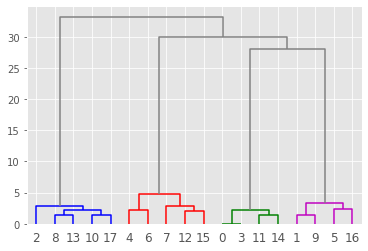

In [ ]:
link_EMP = linkage(EMP, 'ward', 'euclidean')
dn = dendrogram(link_EMP, above_threshold_color="grey")

In [ ]:
dist = link_EMP[:, 2]
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Distance between merged clusters')
plt.xlabel('Step')
plt.ylabel('Distance');

NameError: ignored

In [ ]:
EMP['cluster'] = fcluster(link_EMP, 4, criterion='maxclust')
EMP.groupby('cluster').mean()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
cluster,,,,,,,,,,
1,4.2,4.8,10.00,4.4,10.00,4.4,10.00,4.00,3.80,10.00
2,4.8,4.4,4.00,4.0,4.20,10.0,4.40,10.00,10.00,5.00
3,10.0,10.0,9.00,10.0,10.00,9.5,9.25,9.75,10.00,9.50
4,10.0,10.0,4.25,10.0,4.75,4.5,3.75,4.25,4.25,4.25


1. Память на числа
2. Умение решать математические задачи
3. Находчивость при прямом диалоге
4. Умение составлять алгоритмы
5. Уверенность во время выступления
6. Командный дух
7. Находчивость
8. Сотрудничество
9. Признание в коллективе
10. Сила убеждения

In [ ]:
EMP.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,cluster
NAME,,,,,,,,,,,
Volker,10,10,9,10,10,10,9,10,10,9,3
Sigrid,10,10,4,10,5,5,4,5,4,3,4
Elmar,5,4,10,5,10,4,10,5,3,10,1
Peter,10,10,9,10,10,10,9,10,10,9,3
Otto,4,3,5,4,3,10,4,10,10,5,2


In [ ]:
EMP.columns=['Память на числа',
             'Решение математических задач',
             'Находчивость при диалоге',
             'Составление алгоритмов',
             'Уверенность при выступлениях',
             'Командный дух',
             'Находчивость',
             'Сотрудничество',
             'Признание в коллективе',
             'Сила убеждения',
             'cluster']
EMP.groupby('cluster').mean().T

cluster,1,2,3,4
Память на числа,4.2,4.8,10.00,10.00
Решение математических задач,4.8,4.4,10.00,10.00
Находчивость при диалоге,10.0,4.0,9.00,4.25
Составление алгоритмов,4.4,4.0,10.00,10.00
Уверенность при выступлениях,10.0,4.2,10.00,4.75
Командный дух,4.4,10.0,9.50,4.50
Находчивость,10.0,4.4,9.25,3.75
Сотрудничество,4.0,10.0,9.75,4.25
Признание в коллективе,3.8,10.0,10.00,4.25
Сила убеждения,10.0,5.0,9.50,4.25


Теперь разобъём на 3 кластера:

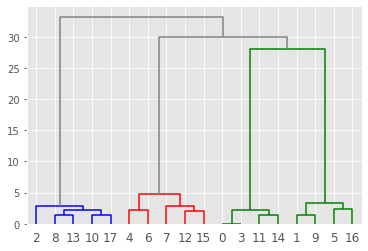

In [ ]:
EMP_3 = pd.read_csv('assess.dat', sep='\t', index_col='NAME')

del EMP_3['NR']

link_EMP_3 = linkage(EMP_3, 'ward', 'euclidean')

dn_emp_3 = dendrogram(link_EMP_3,
                      color_threshold = 29,
                      above_threshold_color="grey"
                     )

In [ ]:
EMP_3['cluster'] = fcluster(link_EMP_3, 3, criterion='maxclust')
EMP_3.groupby('cluster').mean()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
cluster,,,,,,,,,,
1,4.2,4.8,10.000,4.4,10.000,4.4,10.0,4.0,3.800,10.000
2,4.8,4.4,4.000,4.0,4.200,10.0,4.4,10.0,10.000,5.000
3,10.0,10.0,6.625,10.0,7.375,7.0,6.5,7.0,7.125,6.875


In [ ]:
EMP_3.groupby('cluster').size()

cluster
1    5
2    5
3    8
dtype: int64

In [ ]:
#  Кто попал в 3-й кластер?
EMP_3[EMP_3['cluster'] == 3].index.values

array(['Volker', 'Sigrid', 'Peter', 'Elke', 'Siglinde', 'Achim', 'Silke',
       'Manfred'], dtype=object)

In [ ]:
EMP_3.columns=['Память на числа',
             'Решение математических задач',
             'Находчивость при диалоге',
             'Составление алгоритмов',
             'Уверенность при выступлениях',
             'Командный дух',
             'Находчивость',
             'Сотрудничество',
             'Признание в коллективе',
             'Сила убеждения',
             'cluster']
EMP_3.groupby('cluster').mean().T

cluster,1,2,3
Память на числа,4.2,4.8,10.000
Решение математических задач,4.8,4.4,10.000
Находчивость при диалоге,10.0,4.0,6.625
Составление алгоритмов,4.4,4.0,10.000
Уверенность при выступлениях,10.0,4.2,7.375
Командный дух,4.4,10.0,7.000
Находчивость,10.0,4.4,6.500
Сотрудничество,4.0,10.0,7.000
Признание в коллективе,3.8,10.0,7.125
Сила убеждения,10.0,5.0,6.875


Применяем метод k-средних:

В scikit-learn процедура настройки и использования моделей часто проходит по одной и той же схеме:
1. Инициализация модели, задание её параметров,
2. Подгонка модели (метод fit и/или fit_transform),
3. Предсказание для новых наблюдений (метод predict).

Для кластеризации методом k-means необходимо задать k наперёд.

In [ ]:
EMP_k = pd.read_csv('assess.dat', sep='\t', index_col='NAME')

del EMP_k['NR']

In [ ]:
from sklearn.cluster import KMeans

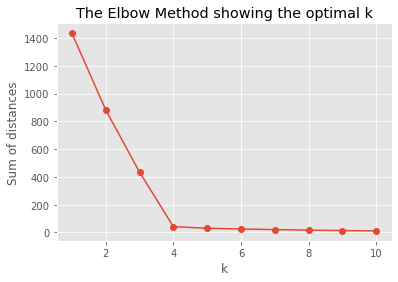

In [ ]:
K = range(1, 11)
models = [KMeans(n_clusters = k, random_state = 42).fit(EMP_k) for k in K]
# random_state - зерно датчика случайных чисел.
# При каждом новом вызове с одинаковыми random_state
# модель будет давать одинаковые результаты.

dist = [model.inertia_ for model in models]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(EMP_k)
EMP_k['cluster'] = model.labels_
EMP_k.groupby('cluster').mean()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
cluster,,,,,,,,,,
0,4.8,4.4,4.00,4.0,4.20,10.0,4.40,10.00,10.00,5.00
1,4.2,4.8,10.00,4.4,10.00,4.4,10.00,4.00,3.80,10.00
2,10.0,10.0,4.25,10.0,4.75,4.5,3.75,4.25,4.25,4.25
3,10.0,10.0,9.00,10.0,10.00,9.5,9.25,9.75,10.00,9.50


In [ ]:
EMP_k.columns=['Память на числа', 'Решение математических задач', 'Находчивость при диалоге',
             'Составление алгоритмов', 'Уверенность при выступлениях', 'Командный дух',
             'Находчивость', 'Сотрудничество', 'Признание в коллективе', 'Сила убеждения',
             'cluster']
EMP_k.groupby('cluster').mean().T

cluster,0,1,2,3
Память на числа,4.8,4.2,10.00,10.00
Решение математических задач,4.4,4.8,10.00,10.00
Находчивость при диалоге,4.0,10.0,4.25,9.00
Составление алгоритмов,4.0,4.4,10.00,10.00
Уверенность при выступлениях,4.2,10.0,4.75,10.00
Командный дух,10.0,4.4,4.50,9.50
Находчивость,4.4,10.0,3.75,9.25
Сотрудничество,10.0,4.0,4.25,9.75
Признание в коллективе,10.0,3.8,4.25,10.00
Сила убеждения,5.0,10.0,4.25,9.50


---
---

## Пример 3. Потребление белков в Европе

Имеется датасет о различных источниках белков (протеинов) в странах Европы в 1970-х годах. В таблице указано среднесуточное потребление белка на душу населения в граммах. Источники белка следующие:

__RedMeat__ - Мясо
__WhiteMeat__ - Птица
__Eggs__ - Яйца
__Milk__ - Молоко
__Fish__ - Рыба
__Cereals__ - Злаковые
__Starch__ - Углеводы
__Nuts__ - Орехи
__Fr&Veg__ - Фрукты и Овощи

Задача: Провести кластерный анализ наблюдений. Постарайтесь найти такой метод кластеризации, чтобы полученные кластеры соответствовали регионам. Надо ли проводить стандартизацию? Как отличаются кластеры?

In [ ]:
EF = pd.read_csv('Protein Consumption in Europe.csv', sep=';', decimal=',', index_col='Country')
EF.head()

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
Country,,,,,,,,,
Albania,10.1,1.4,0.5,8.9,0.2,42.3,0.6,5.5,1.7
Austria,8.9,14.0,4.3,19.9,2.1,28.0,3.6,1.3,4.3
Belgium,13.5,9.3,4.1,17.5,4.5,26.6,5.7,2.1,4.0
Bulgaria,7.8,6.0,1.6,8.3,1.2,56.7,1.1,3.7,4.2
Czechoslovakia,9.7,11.4,2.8,12.5,2.0,34.3,5.0,1.1,4.0


In [ ]:
EF.shape

(25, 9)

__Стандартизация данных__

В этом примере данные, которые мы собираемся кластеризовать, хотя и находятся в одних и тех же единицах измерения, но местами они различаются почти на два порядка, так что будет не лишним их стандартизировать перед анализом.

В модуле preprocessing библиотеки sklearn реализованы несколько классов стандартизации данных:
* StandardScaler -- приведение к нулевому среднему и единичной дисперсии.
* MinMaxScaler -- приведение данных к отрезку [0, 1].
* MaxAbsScaler -- приведение к [-1, 1] (рекомендуется для разреженных данных).

Замечание. У этих методов есть чуть более лёгкие методы-аналоги ```scale```, ```minmax_scale``` и ```maxabs_scale```, которые делают практически то же самое, но для supervized задач машинного обучения, которые встретяся позже, удобнее использовать именно изначально указанные классы.

Процесс стандартизации выглядит так:

In [ ]:
from sklearn import preprocessing

# Выбираем один из вариантов нормализации

norm = preprocessing.StandardScaler()
# norm = preprocessing.MaxAbsScaler()
# norm = preprocessing.MinMaxScaler()

# вычисляем параметры нормализации (они будут сохранены внутри объекта norm)
norm.fit(EF)
# преобразовываем данные с параметрами
X = norm.transform(EF)
# Полученный на предыдущем шаге объект X -- это матрица класса numpy.ndarray.
# Глазами на неё смотреть неудобно, лучше преобразовать её в объект класса pandas.DataFrame.
X = pd.DataFrame(X, index=EF.index, columns=EF.columns)

In [ ]:
X.head()

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
Country,,,,,,,,,
Albania,0.082941,-1.794750,-2.224584,-1.179570,-1.225033,0.934804,-2.295965,1.247968,-1.378251
Austria,-0.282974,1.686446,1.245621,0.400468,-0.655111,-0.395051,-0.422218,-0.910790,0.092789
Belgium,1.119699,0.387905,1.062979,0.055732,0.064791,-0.525246,0.889405,-0.499598,-0.076947
Bulgaria,-0.618396,-0.523837,-1.220051,-1.265754,-0.925074,2.273959,-1.983674,0.322786,0.036210
Czechoslovakia,-0.039031,0.968104,-0.124197,-0.662467,-0.685107,0.190830,0.452198,-1.013588,-0.076947


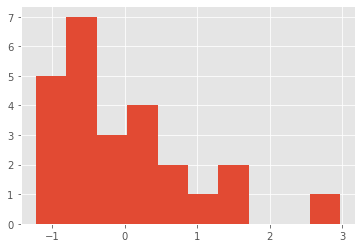

In [ ]:
X['Fish'].hist();

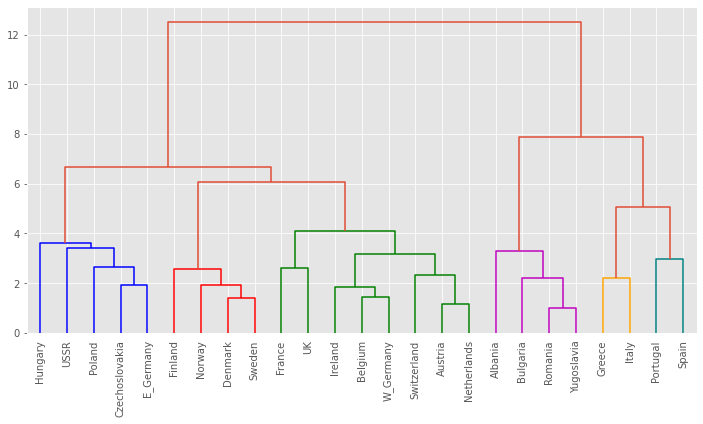

In [ ]:
link_EF = linkage(X, 'ward', 'euclidean')

plt.figure(figsize=(12,6))

dn_EF = dendrogram(link_EF,
                   # массив с названиями объектов для подписи по оси X
                   labels = X.index.tolist(),
                   # опция для более красивого отображения слишком ветвистой дендрограммы
                   #truncate_mode='lastp',
                   color_threshold=5,
                   # повернуть подписи вертикально
                   leaf_rotation=90.)

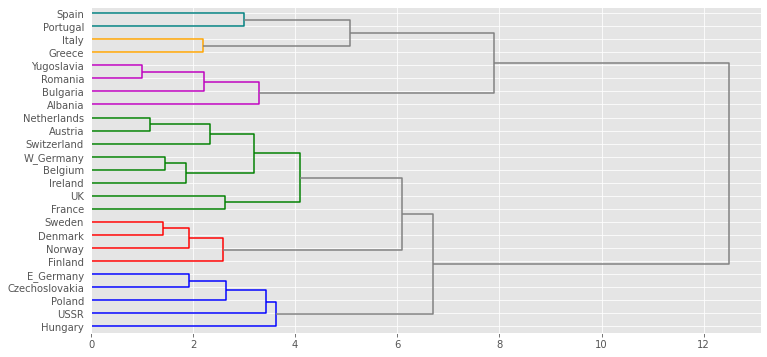

In [ ]:
plt.figure(figsize=(12,6))

dn_EF = dendrogram(link_EF,
                   # массив с названиями объектов для подписи по оси X
                   labels = X.index.tolist(),
                   above_threshold_color="grey",
                   color_threshold=5,
                   orientation = "right"
                  )

In [ ]:
EF['cluster'] = fcluster(link_EF, 5, criterion='distance')
EF.groupby('cluster').mean()

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
cluster,,,,,,,,,
1,7.9200,10.0400,2.8400,13.8400,2.740,35.740,5.56,2.5400,4.260
2,9.8500,7.0500,3.1500,26.6750,8.225,22.675,4.55,1.1750,2.125
3,13.2125,10.6375,3.9875,21.1625,3.375,24.700,4.65,2.0625,4.175
4,7.1250,4.6750,1.2000,9.4500,0.750,51.125,1.95,5.0500,2.975
5,9.6000,4.0500,2.8500,15.6500,4.650,39.250,2.15,6.0500,6.600
6,6.6500,3.5500,2.1000,6.7500,10.600,28.100,5.80,5.3000,7.550


In [ ]:
EF['cluster'].sort_values()

Country
Poland            1
USSR              1
Czechoslovakia    1
E_Germany         1
Hungary           1
Sweden            2
Norway            2
Denmark           2
Finland           2
Netherlands       3
W_Germany         3
France            3
UK                3
Switzerland       3
Belgium           3
Austria           3
Ireland           3
Albania           4
Yugoslavia        4
Romania           4
Bulgaria          4
Greece            5
Italy             5
Portugal          6
Spain             6
Name: cluster, dtype: int32

Применяем метод k-средних:

In [ ]:
EF_k = pd.read_csv('Protein Consumption in Europe.csv', sep=';', decimal=',', index_col='Country')

# Стандартизируем данные
norm = preprocessing.StandardScaler()
norm.fit(EF_k)
X_k = norm.transform(EF_k)
X_k = pd.DataFrame(X_k, index=EF_k.index, columns=EF_k.columns)
X_k.head()

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
Country,,,,,,,,,
Albania,0.082941,-1.794750,-2.224584,-1.179570,-1.225033,0.934804,-2.295965,1.247968,-1.378251
Austria,-0.282974,1.686446,1.245621,0.400468,-0.655111,-0.395051,-0.422218,-0.910790,0.092789
Belgium,1.119699,0.387905,1.062979,0.055732,0.064791,-0.525246,0.889405,-0.499598,-0.076947
Bulgaria,-0.618396,-0.523837,-1.220051,-1.265754,-0.925074,2.273959,-1.983674,0.322786,0.036210
Czechoslovakia,-0.039031,0.968104,-0.124197,-0.662467,-0.685107,0.190830,0.452198,-1.013588,-0.076947


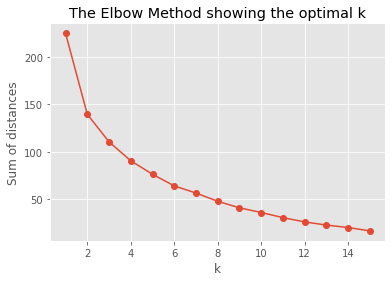

In [ ]:
K = range(1, 16)
models = [KMeans(n_clusters = k).fit(X_k) for k in K]
dist = [model.inertia_ for model in models]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
model = KMeans(n_clusters = 6)
model.fit(X_k)
X_k['cluster'] = model.labels_
X_k.groupby('cluster').mean()

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
cluster,,,,,,,,,
0,-0.969064,-1.200736,-0.763445,-1.488396,1.894541,-0.385751,0.951864,1.145170,1.931589
1,1.219890,0.624721,0.919474,0.607720,-0.218027,-0.745782,0.327281,-0.462885,0.011962
2,-0.935522,-0.463054,-1.274844,-1.093386,-1.087052,1.550444,-1.196700,1.052652,-0.518259
3,0.006708,-0.233737,0.195427,1.373628,1.182139,-0.890259,0.171136,-0.975039,-1.137793
4,-0.362255,0.680767,0.168031,-0.176964,-0.355152,0.099693,0.751997,-0.694914,0.081473
5,-0.069524,-1.062594,-0.078536,-0.210001,0.109785,0.651164,-1.327862,1.530662,1.394093


In [ ]:
X_k['cluster'].sort_values()

Country
Spain             0
Portugal          0
UK                1
Belgium           1
Switzerland       1
Netherlands       1
France            1
W_Germany         1
Ireland           1
Albania           2
Romania           2
Yugoslavia        2
Bulgaria          2
Hungary           2
Finland           3
Norway            3
Denmark           3
Sweden            3
Poland            4
E_Germany         4
Czechoslovakia    4
Austria           4
USSR              4
Greece            5
Italy             5
Name: cluster, dtype: int32

---
Посмотрим на кластеризацию нестандартизованных данных:

In [ ]:
model = KMeans(n_clusters = 6)
model.fit(EF_k)
EF_k['cluster'] = model.labels_
EF_k.groupby('cluster').mean()

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
cluster,,,,,,,,,
0,6.133333,5.766667,1.433333,9.633333,0.933333,54.066667,2.400000,4.900000,3.400000
1,12.957143,10.442857,3.900000,18.742857,3.957143,25.114286,4.757143,1.985714,4.342857
2,9.650000,3.525000,2.075000,14.200000,3.125000,41.100000,2.825000,5.250000,4.450000
3,6.650000,3.550000,2.100000,6.750000,10.600000,28.100000,5.800000,5.300000,7.550000
4,10.466667,8.633333,3.483333,25.983333,6.266667,22.850000,4.766667,1.350000,2.516667
5,7.300000,11.333333,2.800000,13.833333,1.766667,36.833333,4.966667,2.833333,4.933333


In [ ]:
EF_k['cluster'].sort_values()

Country
Yugoslavia        0
Bulgaria          0
Romania           0
Austria           1
Belgium           1
UK                1
E_Germany         1
Switzerland       1
France            1
W_Germany         1
USSR              2
Albania           2
Greece            2
Italy             2
Portugal          3
Spain             3
Netherlands       4
Norway            4
Sweden            4
Finland           4
Denmark           4
Ireland           4
Hungary           5
Poland            5
Czechoslovakia    5
Name: cluster, dtype: int32

---
---
# __Домашнее задание__ <a class="anchor" id="HW"></a>

Набор данных ```candies.dat``` содержит оценки степени согласия (от 1 до 5 баллов) респондентов с высказываниями, отражающими цель потребления леденцов. Всего каждый респондент выставлял оценки по 11 высказываниям:

V1: Я потребляю леденцы, чтобы освежить дыхание
V2: Я потребляю леденцы, чтобы чувствовать себя увереннее
V3: Я потребляю леденцы, чтобы освежить полость рта
V4: Я потребляю леденцы, чтобы избавиться от неприятного вкуса во рту
V5: Я потребляю леденцы как заменитель других кондитерских изделий
V6: Я потребляю леденцы, когда мне хочется чего-нибудь сладкого
V7: Леденцы помогают мне сконцентрироваться
V8: Я потребляю леденцы, чтобы отвлечься на несколько минут и подумать
V9: Я потребляю леденцы для того, чтобы облегчить боль в горле
V10: Я потребляю леденцы для того, чтобы избавиться от заложенности носа
V11: Я потребляю леденцы для улучшения самочувствия

__Задание:__ Определить число кластеров. Подобрать метод классификации, дающий наиболее ясные результаты. Какие леденцы пользуются популярностью у потребителей из каждого сегмента?

> __Комментарий:__ Поскольку анализируется большой набор данных, процедура может работать долго.
__Подсказка:__ используйте аргумент ```truncate_mode='lastp'``` при построении дендрограммы

*Курсив*---
---